<a href="https://colab.research.google.com/github/testanalyst/99-minute-ci-cd-pipeline/blob/main/Sanity_Test_2025_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import random, string, re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
class DataGenerator:
    def __init__(self, n_samples=1000, missing_rate=0.2, duplicate_rate=0.1):
        self.n_samples = n_samples
        self.missing_rate = missing_rate
        self.duplicate_rate = duplicate_rate
        np.random.seed(42)

    def _generate_base_fields(self):
        return {
            'name_first': [''.join(random.choices(string.ascii_letters, k=6)) for _ in range(self.n_samples)],
            'name_last': [''.join(random.choices(string.ascii_letters, k=8)) for _ in range(self.n_samples)],
            'email': self._generate_emails(),
            'phone': self._generate_phones(),
            'address1': self._generate_addresses(),
            'address2': [f'Apt {random.randint(1,999)}' for _ in range(self.n_samples)],
            'zip': [str(random.randint(10000,99999)) for _ in range(self.n_samples)],
            'state': [random.choice(['CA','NY','TX','FL','IL']) for _ in range(self.n_samples)],
            'country': ['USA' for _ in range(self.n_samples)]
        }

    def _generate_emails(self):
        return [f"{''.join(random.choices(string.ascii_letters, k=6))}@{''.join(random.choices(string.ascii_letters, k=6))}.com"
                if random.random() > 0.1 else 'invalid@' for _ in range(self.n_samples)]

    def _generate_phones(self):
        return [f"{random.randint(100,999)}-{random.randint(100,999)}-{random.randint(1000,9999)}"
                if random.random() > 0.15 else '123-XXX' for _ in range(self.n_samples)]

    def _generate_addresses(self):
        return [''.join(random.choices(string.ascii_letters + string.digits + ' ', k=20))
                for _ in range(self.n_samples)]

    def create_dataset(self):
        data = self._generate_base_fields()
        df = pd.DataFrame(data)

        # Add missing values
        for col in df.columns:
            mask = np.random.random(len(df)) < self.missing_rate
            df.loc[mask, col] = np.nan

        # Add duplicates
        n_duplicates = int(self.duplicate_rate * self.n_samples)
        duplicate_indices = np.random.choice(len(df), n_duplicates)
        df.iloc[duplicate_indices] = df.iloc[0:n_duplicates].values

        return df

# Generate dataset
generator = DataGenerator(n_samples=1000)
df = generator.create_dataset()
print("Dataset shape:", df.shape)
df.tail(100)

Dataset shape: (1000, 9)


,name_first,name_last,email,phone,address1,address2,zip,state,country
900,Hvpuno,bobeNztq,NaN,202-296-4303,NaN,Apt 473,42333,CA,USA
901,NaN,NaN,Owlhlt@AqZJTO.com,962-384-6564,bA6pWnfUHBFqPkPF2qLM,Apt 422,NaN,NY,USA
902,NaN,xIzeAoMg,NaN,331-320-3835,NaN,NaN,NaN,NY,USA
903,teFtUM,NaN,invalid@,210-342-5079,nCz2pxJ1C2rPui2cxYS3,Apt 630,75831,NY,USA
904,TmJvDx,MTZYmlrY,ICroCb@oiGBoZ.com,123-XXX,gDxYW4ckf5cqwIHCHG C,NaN,19729,NaN,USA
...,...,...,...,...,...,...,...,...,...
995,NaN,SkqnPZQK,zLwaIl@DJguGL.com,214-437-3229,Nj7wF1AfnMmnIRFVXGMn,Apt 344,66234,TX,USA
996,VGgBDo,LIDVJqPL,NaN,123-XXX,NaN,Apt 964,38050,CA,NaN
997,NaN,NaN,jyOihJ@nDphyF.com,973-600-9467,IWvwrItvS25Gun3mt3NO,Apt 571,86164,IL,USA
998,AwbqUT,NaN,ZvReat@YjjoTs.com,137-357-9888,MynUArUl6LBBkTvxgxRN,Apt 668,72516,FL,NaN


In [6]:
class DataValidator:
    @staticmethod
    def validate_email(email):
        if pd.isna(email): return False
        pattern = r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
        return bool(re.match(pattern, email))

    @staticmethod
    def validate_phone(phone):
        if pd.isna(phone): return False
        pattern = r'^\d{3}-\d{3}-\d{4}$'
        return bool(re.match(pattern, phone))

    @staticmethod
    def validate_zip(zip_code):
        if pd.isna(zip_code): return False
        return len(str(zip_code)) == 5 and str(zip_code).isdigit()

validator = DataValidator()
validation_results = {
    'email_valid': df['email'].apply(validator.validate_email),
    'phone_valid': df['phone'].apply(validator.validate_phone),
    'zip_valid': df['zip'].apply(validator.validate_zip)
}
print("Validation Results:")
for field, result in validation_results.items():
    print(f"{field}: {sum(result)/len(result)*100:.1f}% valid")

Validation Results:
email_valid: 71.5% valid
phone_valid: 66.7% valid
zip_valid: 79.2% valid


In [7]:
class FeatureEngineer:
    def __init__(self, validator):
        self.validator = validator

    def engineer_features(self, df):
        features = pd.DataFrame()
        features['email_valid'] = df['email'].apply(self.validator.validate_email).astype(int)
        features['phone_valid'] = df['phone'].apply(self.validator.validate_phone).astype(int)
        features['zip_valid'] = df['zip'].apply(self.validator.validate_zip).astype(int)
        features['address_complete'] = (~df[['address1','address2','zip','state']].isna()).sum(axis=1)
        features['name_complete'] = (~df[['name_first','name_last']].isna()).all(axis=1).astype(int)
        features['has_duplicates'] = df.duplicated(subset=['email','phone'], keep=False).astype(int)
        return features

engineer = FeatureEngineer(validator)
features = engineer.engineer_features(df)
features_scaled = StandardScaler().fit_transform(features)
print("Features shape:", features.shape)
features.head()

Features shape: (1000, 6)


,email_valid,phone_valid,zip_valid,address_complete,name_complete,has_duplicates
0,0,1,1,3,0,1
1,1,1,0,2,1,1
2,0,1,1,4,1,1
3,1,1,1,3,1,1
4,1,1,0,2,0,1


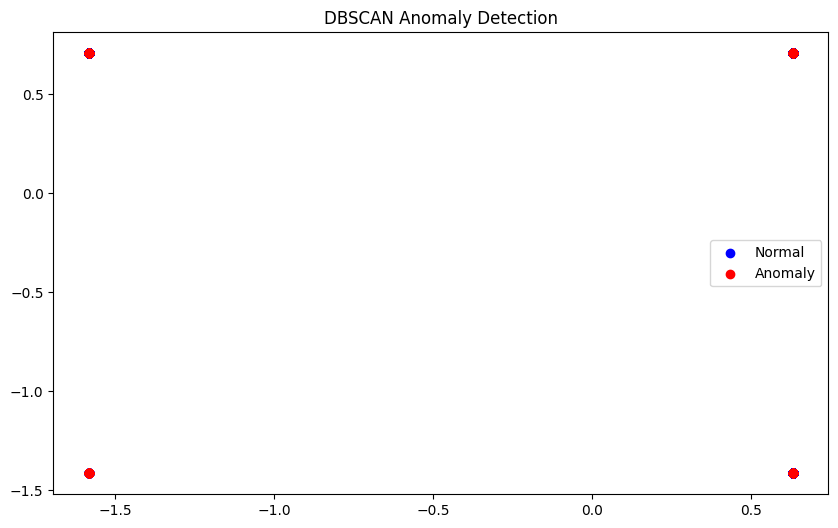

Anomalies detected: 77 (7.7%)


In [8]:
class AnomalyDetector:
    def __init__(self, eps=0.5, min_samples=5):
        self.detector = DBSCAN(eps=eps, min_samples=min_samples)

    def detect(self, features_scaled):
        return self.detector.fit_predict(features_scaled)

    def visualize(self, features_scaled, clusters):
        plt.figure(figsize=(10, 6))
        plt.scatter(features_scaled[clusters != -1, 0], features_scaled[clusters != -1, 1],
                   c='blue', label='Normal')
        plt.scatter(features_scaled[clusters == -1, 0], features_scaled[clusters == -1, 1],
                   c='red', label='Anomaly')
        plt.title('DBSCAN Anomaly Detection')
        plt.legend()
        plt.show()

detector = AnomalyDetector()
clusters = detector.detect(features_scaled)
detector.visualize(features_scaled, clusters)

df['anomaly'] = clusters == -1
print(f"Anomalies detected: {sum(df['anomaly'])} ({sum(df['anomaly'])/len(df)*100:.1f}%)")

In [9]:
class DataCleaner:
    def clean_data(self, df, anomaly_mask):
        clean_df = df[~anomaly_mask].copy()
        clean_df['phone'] = clean_df['phone'].apply(
            lambda x: re.sub(r'(\d{3})-(\d{3})-(\d{4})', r'\1\2\3', str(x))
            if validator.validate_phone(x) else x)
        clean_df['zip'] = clean_df['zip'].apply(
            lambda x: x.zfill(5) if validator.validate_zip(x) else x)
        clean_df['state'] = clean_df['state'].str.upper()
        return clean_df

cleaner = DataCleaner()
clean_df = cleaner.clean_data(df, df['anomaly'])

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
df.to_csv(f'original_data_{timestamp}.csv', index=False)
clean_df.to_csv(f'clean_data_{timestamp}.csv', index=False)

print("Original shape:", df.shape)
print("Clean shape:", clean_df.shape)
print("\nCleaned Data Sample:")
clean_df.head()

Original shape: (1000, 10)
Clean shape: (923, 10)

Cleaned Data Sample:


,name_first,name_last,email,phone,address1,address2,zip,state,country,anomaly
0,UTYeuq,NaN,invalid@,9548489947,2VqX5df8EcLdpy waEW7,Apt 889,52949,NaN,USA,False
2,FzMDlp,PTiULDjK,invalid@,8684964373,iWZeNbMdxu1TX1TUHuHV,Apt 647,96571,TX,NaN,False
3,AosCZl,iutrPtFQ,ezrmOz@tVNnYw.com,3753289669,NaN,Apt 443,42332,IL,USA,False
5,NaN,AVkzVSyE,FPDqCS@IKfOUk.com,3266022351,Un90GNMF3woqRBx71slb,NaN,74037,CA,USA,False
6,NaN,xUsUBtHr,husZQL@XiFJzk.com,4461827967,1KdOeSGKnMxEsTplztim,Apt 371,70961,NY,USA,False
